
# 0 : Real-time analysis of wikipedia updates
This notebook is the first in a series showing the progression of a developer or data professional with developer skills moving from data exploration, via modular application building, to delivering consumable visualizations on Machine Learning-based analysis.

- Data exploration in pure python
- Data aggregation and filtering
- Data windowing
- Data extraction
- Image analysis

We are exploring a publicly available and accessible streaming data source from mediawiki.org. MediaWiki is a free and open-source software package written in PHP, originally for use on Wikipedia. The website maintained to promote this open-source offering offers an accessible feed of changes to all of the pages and assets that make it up. People editing MediaWiki pages are around the world, working in different languages.

# Streaming data exploration

Data science projects commonly start with a data set with defined characteristcs. A data professional will explore the data and assess it for completeness, quality, and relevance to the project purpose.

For streaming data, the process is similar even though the actual data elements are constantly changing. This notebook shows those first exploration steps to allow a data professional to understand the data they are presented with for analysis.

The specification of the mediawiki feed can be found here. https://wikitech.wikimedia.org/wiki/Event_Platform/EventStreams

The data is streamed using the Server-Sent Events (SSE) protocol. This is similar in some respects to Websockets, but SSE is one-way only and uses HTTP as the transport. 

The feed itself is available here: https://stream.wikimedia.org/v2/stream/recentchange

In this exploration phase we are using Python in a Jupyter notebook. In later steps the code we develop here will become the seed for our Streams application.

In [1]:
!pip install SSEClient===0.0.22 --upgrade --user

  Created wheel for SSEClient: filename=sseclient-0.0.22-cp36-none-any.whl size=5224 sha256=33a758591a90e3ef5cec1eac584989d9e8e5253b79fbf59d1566778df1b9b64b
  Stored in directory: /home/wsuser/.cache/pip/wheels/fc/b8/5c/c7e0a8161e61dc1ab00c0b5a1a34a3887eb47170ae1a46f7b1
Successfully built SSEClient


In [2]:
from IPython.display import display, clear_output
from sseclient import SSEClient as EventSource
import time
import json
from statistics import mean
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.width', 160)    # Keep dataframe print output from wrapping

%matplotlib inline

### Define functions and helpers to use for data exploration

In [3]:
# This is the core function for tapping into the feed
def get_events(url="https://stream.wikimedia.org/v2/stream/recentchange"):
    """Fetch recent changes from wikievents site using SSE."""
    for change in EventSource(url):         # for each change record in this fetch
        if len(change.data):                # if the change contains any data
            yield json.loads(change.data)   # return it as a json object
                 
def catchInterrupt(func):
    """Decorator: Catch keyboard interrupt to avoid losing the display.
       TODO * <view>.stop_data_fetch()  # stop
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt):
            pass

    return catch_interrupt

@catchInterrupt
def sample_events(wait_between=5, iterations=1):
    """Fetch events from Wikipedia, display and repeat. 
    NOTE: 
        Helper to look at the raw feed, with this you can see all the fields returned
    Args:
        - wait_between : seconds to wait between samples
        - iterations   : number of iterations, < 0 = infinite
    """
    for evt in get_events():
        if iterations == 0: break
        iterations -= 1
        print(json.dumps(evt, indent=1, sort_keys=True))
        time.sleep(wait_between)
        clear_output(wait=True)

The next cell displays a subset of the fields that are available. Invoking
`sample_events()` will return the full complement of fields. 

In [4]:
@catchInterrupt
def table_events(chunk_size=10, column_keys=[], iterations=10):
    """Display selected columns in a table, chunk_size rows at a time.
    Args:
        - column_keys : columns to display
        - chunk_size  : number of rows to show at a time
        - iterations  : number of times to loop, <=0 is infinite
    """
    while iterations != 0:
        lst = []
        iterations -= 1
        for evt in get_events():
            lst.append(evt)
            if len(lst) >= chunk_size: break
        dList = pd.DataFrame(lst)
        print(dList[column_keys])
        clear_output(wait=True)
        
table_events(column_keys=["type", "bot", "user", "wiki", "title"])

         type    bot             user          wiki                                              title
0  categorize  False        Mabschaaf        dewiki  Kategorie:Wikipedia:Vorlagen-Parameterfehler/P...
1        edit  False       Inexpiable        enwiki  List of offenders scheduled to be executed in ...
2        edit  False        Asqueladd  wikidatawiki                                          Q77605455
3        edit   True    BotMultichill  wikidatawiki                                          Q77605630
4        edit  False            Af420        enwiki                                     Tetsu Nakamura
5         new  False  Julietdeltalima        enwiki                          User talk:Robtractortm120
6         new   True      TuanminhBot        viwiki                 Thảo luận Thành viên:123.18.194.94
7        edit  False      HitomiAkane  wikidatawiki                                           Q1872942
8         log  False          Jordi G   commonswiki       File:Mare de Dé

## Focus on event type

Events are characterized with the possible values of: new, edit, catagorize, and log. 
We'll drill down into event types arriving, showing the counts for a chunk of 20 events and averaging over
5 chunks. 


In [5]:
# Aggregate over collections ("chunks") of rows by category

class chunking_average:
    """Aggregate (take the mean of) values over a sliding window
    of counts per category.
    """
    
    def __init__(self, init_base, mean_elements=20):
        """Initialize chunking_average object with counts of zero
        for each of the categories indicated in init_base.
        
        Args:
        - init_base     : dict whose keys indicate the categories to be
                          aggregated separately (values are ignored)
        - mean_elements : size of the chunk over which to take the mean
        """
        
        # For each category, maintain a deque containing the last mean_elements
        # counts. This represents a sliding window: once the deque is full, each
        # new addition drops the oldest entry.
        self.deques = {key:deque([0],maxlen=mean_elements) for key in init_base.keys()}

    def aggregate(self, chunk):
        """Perform the aggregation (calculate the mean) over the current sliding window
        
        Args:
        - chunk : dict of category:count pairs. Counts (values) are appended to the
                  deque for each category (key), potentially dropping the oldest elements
        
        Returns: dict of category:average-count, with the average computed over the accumulated
                 counts for each category (the sliding window), including the current addition
        """
        
        for key in self.deques.keys():
            if self.deques[key] and chunk[key]: self.deques[key].append(chunk[key])
        
        return {key:mean(self.deques[key]) for key in self.deques.keys()}

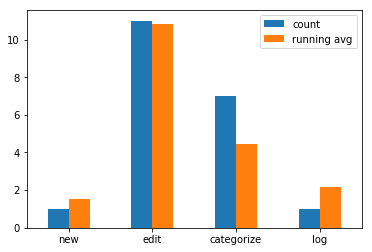

In [6]:
# tally the types

@catchInterrupt
def graph_type(events_window=20, average_windows=5, iterations=5):
    """Display a graph of counts per event type, for the current "chunk"
    and as an average over the last several chunks. 
    
    Args:
        - events_window   : number of events within a chunk
        - average_windows : number of chunks to average (length of a sliding window)
        - iterations      : number of times through this process after filling the sliding window
    """
    
    iterations += average_windows
    cnt = dict({"new":0, "edit":0, "categorize":0,"log":0})
    run_avg = chunking_average(cnt)
    print("Window countdown ...")

    while iterations != 0:
        iterations -= 1

        # Accumulate a chunk's worth of events
        # and accumulate counts per event type
        for evt in get_events():
            if evt['type'] in cnt:
                cnt[evt['type']] += 1
                if sum(cnt.values()) >= events_window: break

        # Add the current chunk stats to the sliding window
        avg = run_avg.aggregate(cnt)
        clear_output(wait=True)

        # If the sliding window is full, show results as iteration continues
        if average_windows <= 0:
            nam_list = cnt.keys()
            evt_list = [cnt[key] for key in nam_list]
            avg_list = [avg[key] for key in nam_list]
            df = pd.DataFrame({'count': evt_list, 'running avg': avg_list}, index=nam_list)
            df.plot.bar(rot=0)
            plt.show()
        else:      # Otherwise, keep accumulating counts until the window is full
            print("Window countdown ... {}".format(average_windows))
            average_windows -= 1

        cnt = {key:0 for key in cnt}

graph_type()

## Notebook wrapup

With this notebook we've accessed live Wikipedia data, done rudimentary calculations, and graphed it.
Since all the components are in a notebook, data is only collected while the notebook is open, which 
provides only limited insight into what is happening. 

Collecting the data continuously is the next phase. In addition to the collecting we'll do some intial processing 
of the live data to make it more consumable. 
